In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
from pm4py.objects.petri_net.obj import PetriNet, Marking
from pm4py.objects.log.importer.xes import importer as xes_importer
from datetime import date
from pm4py.objects.petri_net.importer import importer as pnml_importer
from pm4py.visualization.petri_net import visualizer as pn_visualizer
import seaborn as sns
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\Users\bittu\anaconda3\envs\env-IDS2020\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:

log = xes_importer.apply('../data/2000casebpi2019.xes')
#log = xes_importer.apply('../data/syntheticlogdelaydoctorcase.xes')

parsing log, completed traces ::   0%|          | 0/2000 [00:00<?, ?it/s]

In [5]:
print(log[0])

{'attributes': {'concept:name': '1'}, 'events': [{'concept:name': 'register patient', 'time:timestamp': datetime.datetime(2020, 1, 31, 10, 30), 'org:resource': 3}, '..', {'concept:name': 'hospital exit', 'time:timestamp': datetime.datetime(2020, 1, 31, 17, 30), 'org:resource': 1}]}


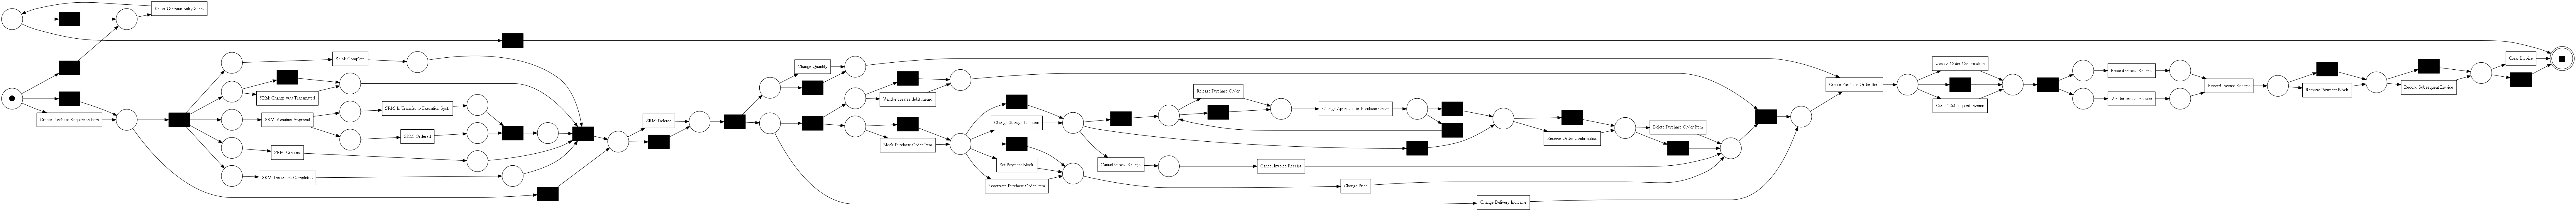

In [4]:
net, initial_marking, final_marking = pnml_importer.apply("../data/2000petrinetbpi2019.pnml")    

#net, initial_marking, final_marking = pnml_importer.apply("../data/syntheticnetdoctor.pnml")    


gviz = pn_visualizer.apply(net, initial_marking, final_marking)
pn_visualizer.view(gviz)


In [5]:
from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
replayed_traces = token_replay.apply(log, net, initial_marking, final_marking)

replaying log with TBR, completed variants ::   0%|          | 0/318 [00:00<?, ?it/s]

In [14]:
#for trace in replayed_traces:
#    print(trace)

In [6]:
len(replayed_traces)

500

In [6]:
net

places: [ n1, n10, n11, n12, n13, n14, n15, n16, n17, n18, n19, n2, n20, n21, n22, n23, n24, n25, n26, n27, n28, n29, n3, n30, n31, n32, n33, n34, n35, n36, n37, n38, n39, n4, n40, n41, n42, n43, n44, n45, n46, n47, n5, n6, n7, n8, n9 ]
transitions: [ (n100, 'Record Invoice Receipt'), (n101, None), (n102, 'Remove Payment Block'), (n103, None), (n104, 'Record Subsequent Invoice'), (n105, None), (n106, 'Clear Invoice'), (n107, None), (n108, 'Record Service Entry Sheet'), (n109, None), (n110, None), (n48, None), (n49, 'Create Purchase Requisition Item'), (n50, None), (n51, None), (n52, None), (n53, 'SRM: Created'), (n54, 'SRM: Document Completed'), (n55, 'SRM: Complete'), (n56, None), (n57, 'SRM: Change was Transmitted'), (n58, 'SRM: Awaiting Approval'), (n59, None), (n60, 'SRM: In Transfer to Execution Syst.'), (n61, 'SRM: Ordered'), (n62, None), (n63, 'SRM: Deleted'), (n64, None), (n65, None), (n66, 'Change Quantity'), (n67, None), (n68, None), (n69, None), (n70, 'Vendor creates debit m

In [11]:
##usage= get_labels_set(input_transition_set)
def get_labels_set(input_transition_set):
    label_set=set()
    for transition in input_transition_set:
        label_set.add(transition._Transition__get_label())
    return label_set

In [12]:
##usage= get_input_transitions('n4')
def get_initial_start(intial_place):
    for place in net.places:
        if place._Place__get_name()==intial_place:
            initial_start=place
    return initial_start

In [13]:
##usage= get_input_transitions(net,initial_start)
def get_input_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_target()==place:
                if arc._Arc__get_source()._Transition__get_label() is None:
                    for new_place in arc._Arc__get_source()._Transition__get_in_arcs():
                        transition.extend(get_input_transitions(net,new_place._Arc__get_source()))
                else:
                    transition.append(arc._Arc__get_source())
        return transition
    else:
        return None

In [14]:
##usage= get_output_transitions(net,initial_start)
def get_output_transitions(net,place):
    transition=list()
    if place in net.places:
        for arc in net.arcs:
            if arc._Arc__get_source()==place:
                if arc._Arc__get_target()._Transition__get_label() is None:
                    for new_place in arc._Arc__get_target()._Transition__get_out_arcs():
                        transition.extend(get_output_transitions(net,new_place._Arc__get_target()))
                else:
                    transition.append(arc._Arc__get_target())
        return transition
    else:
        return None

# for sample log n42,n40 (Predictor Zone delayed test)
Input
   {(n98, 'Record Goods Receipt'), (n99, 'Vendor creates invoice')->(n42,n40)
    
Output-
    (n42,n40)->('Record Invoice Receipt') 

In [15]:
input_transition_set=set()
input_transition_label_set=set()
output_transition_set=set()
output_transition_label_set=set()
for start in ['n4','n19','n20','n22']:
    initial_start=get_initial_start(start)
    input_transition_set|=set(get_input_transitions(net,initial_start))
    output_transition_set|=set(get_output_transitions(net,initial_start))
    
temp=input_transition_set.difference(output_transition_set)
output_transition_set.difference_update(input_transition_set)
input_transition_set=temp    

input_transition_label_set|=get_labels_set(input_transition_set)    
output_transition_label_set|=get_labels_set(output_transition_set)

print(input_transition_set)
print(input_transition_label_set)
print(output_transition_set)
print(output_transition_label_set)

token_produced=0
token_consumed=0
token_left=0
predictordf=pd.DataFrame(columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
for trace,case in zip(replayed_traces, log):
    last_event=None
    first_event=None
    if trace['trace_is_fit']==True:
        for active_trace in trace['activated_transitions']:
            if active_trace in input_transition_set :
                for events in case:
                    if events['concept:name'] in input_transition_label_set:
                        last_event=events
            if active_trace in output_transition_set:
                for events in case:
                    if events['concept:name'] in output_transition_label_set and first_event is None:
                        first_event=events
    if last_event is not None and first_event is not None:
        token_produced=token_produced+1
        token_consumed=token_consumed+1
        row_df = pd.DataFrame([[last_event['concept:name'], last_event['time:timestamp'],first_event['concept:name'], first_event['time:timestamp'], case.attributes['concept:name']]],columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
        predictordf = pd.concat([row_df, predictordf], ignore_index=True)
    
print(token_produced)
print(token_consumed)

predictordf

{(n54, 'SRM: Document Completed'), (n60, 'SRM: In Transfer to Execution Syst.'), (n53, 'SRM: Created'), (n57, 'SRM: Change was Transmitted'), (n49, 'Create Purchase Requisition Item'), (n55, 'SRM: Complete'), (n61, 'SRM: Ordered')}
{'SRM: Ordered', 'SRM: Created', 'Create Purchase Requisition Item', 'SRM: In Transfer to Execution Syst.', 'SRM: Complete', 'SRM: Change was Transmitted', 'SRM: Document Completed'}
{(n90, 'Cancel Goods Receipt'), (n83, 'Change Approval for Purchase Order'), (n93, 'Create Purchase Order Item'), (n75, 'Set Payment Block'), (n92, 'Change Delivery Indicator'), (n66, 'Change Quantity'), (n76, 'Change Price'), (n74, 'Reactivate Purchase Order Item'), (n89, 'Delete Purchase Order Item'), (n87, 'Receive Order Confirmation'), (n82, 'Release Purchase Order'), (n70, 'Vendor creates debit memo'), (n72, 'Block Purchase Order Item'), (n78, 'Change Storage Location')}
{'Reactivate Purchase Order Item', 'Block Purchase Order Item', 'Set Payment Block', 'Change Quantity', 

,StartEvent,StartTime,EndEvent,EndTime,User
0,Create Purchase Requisition Item,2018-12-21 00:00:00+01:00,Create Purchase Order Item,2018-12-21 09:14:00+01:00,4508075769_00020
1,Create Purchase Requisition Item,2018-12-21 00:00:00+01:00,Create Purchase Order Item,2018-12-21 08:42:00+01:00,4508075763_00010
2,Create Purchase Requisition Item,2018-12-18 00:00:00+01:00,Create Purchase Order Item,2018-12-18 09:03:00+01:00,4508074870_00100
3,Create Purchase Requisition Item,2018-12-18 00:00:00+01:00,Create Purchase Order Item,2018-12-18 07:49:00+01:00,4508074851_00020
4,Create Purchase Requisition Item,2018-12-17 00:00:00+01:00,Create Purchase Order Item,2018-12-17 10:28:00+01:00,4508074605_00040
...,...,...,...,...,...
180,SRM: Ordered,2018-05-17 17:13:00+02:00,Create Purchase Order Item,2018-05-17 17:13:00+02:00,2000013650_00001
181,SRM: In Transfer to Execution Syst.,2018-05-17 17:10:00+02:00,Create Purchase Order Item,2018-05-17 17:10:00+02:00,2000013647_00003
182,Create Purchase Requisition Item,2018-02-06 00:00:00+01:00,Create Purchase Order Item,2018-02-07 18:18:00+01:00,4507008279_00010
183,Create Purchase Requisition Item,2018-02-01 00:00:00+01:00,Create Purchase Order Item,2018-02-01 17:31:00+01:00,4507007150_00010


In [16]:
predictordf['StartDateTime'] = pd.to_datetime(predictordf['StartTime'], utc=True)
predictordf['StartDate'] = pd.to_datetime(predictordf['StartDateTime']).dt.date
predictordf['EndDateTime'] = pd.to_datetime(predictordf['EndTime'], utc=True)
predictordf['EndDate'] = pd.to_datetime(predictordf['EndDateTime']).dt.date
predictordf['TotalWaitingTime']=  (pd.to_datetime(predictordf['EndTime'], utc=True)-pd.to_datetime(predictordf['StartTime'], utc=True))
minstartdate=min(predictordf['StartDate'])
maxenddate=max(predictordf['EndDate'])

#freq- H, D, 7D, M
freq='D'

In [17]:
predictordatedataframe = pd.DataFrame({'date':pd.date_range(start=minstartdate, end=maxenddate,freq=freq),'tokenproduced':0,'tokenconsumed':0,'tokenleft':0,'WaitingTime':0,'Count':0})
predictordatedataframe 

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count
0,2018-01-02,0,0,0,0,0
1,2018-01-03,0,0,0,0,0
2,2018-01-04,0,0,0,0,0
3,2018-01-05,0,0,0,0,0
4,2018-01-06,0,0,0,0,0
...,...,...,...,...,...,...
349,2018-12-17,0,0,0,0,0
350,2018-12-18,0,0,0,0,0
351,2018-12-19,0,0,0,0,0
352,2018-12-20,0,0,0,0,0


In [18]:
from datetime import timedelta as td
for index, row in predictordatedataframe.iterrows():
    currentdate=row['date']
    produced=0
    left=0
    consumed=0
    waiting=td(days=0)
    waitingdays=0
    #print(type(waiting))
    count=0
    #if currentdate.strftime('%Y-%m-%d')<='2018-11-16':
    #    continue
    for indexdata, rowdata in predictordf.iterrows():
        StartDate=rowdata['StartDate']
        EndDate=rowdata['EndDate']
        #TotalWaitingTime=rowdata['TotalWaitingTime']
        TotalWaitingTime=rowdata['TotalWaitingTime']
        #print(type(waiting)," ",type(TotalWaitingTime))
        WaitingTimeTillDate=currentdate+td(hours=24)
        if currentdate.date()==StartDate:
            produced=produced+1
        if currentdate.date()==EndDate:
            consumed=consumed+1
            WaitingTimeTillDate=rowdata['EndDateTime']
        if currentdate.date()<EndDate and currentdate.date()>=StartDate:
            left=left+1
        if currentdate.date()<=EndDate and currentdate.date()>=StartDate:
            TotalWaitingTime=WaitingTimeTillDate.replace(tzinfo=None)-rowdata['StartDateTime'].replace(tzinfo=None)
            if waiting is None:
                waiting=TotalWaitingTime
            else:
                if waiting.days<100000:
                    waiting=waiting+TotalWaitingTime
                    waitingdays=waiting.days
                else :
                    waitingdays=TotalWaitingTime.days+waitingdays
            count=count+1
    predictordatedataframe.at[index, 'tokenproduced']=produced
    predictordatedataframe.at[index, 'tokenconsumed']=consumed
    predictordatedataframe.at[index, 'tokenleft']=left
    if waiting.days<100000:
        predictordatedataframe.at[index, 'WaitingTime']=waiting
    else:
        predictordatedataframe.at[index, 'WaitingTime']=waitingdays
    predictordatedataframe.at[index, 'Count']=count

In [19]:
predictordatedataframe.sort_values(by='date')

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count
0,2018-01-02,1,0,1,0 days 01:00:00,1
1,2018-01-03,0,1,0,0 days 13:51:00,1
2,2018-01-04,0,0,0,0:00:00,0
3,2018-01-05,0,0,0,0:00:00,0
4,2018-01-06,0,0,0,0:00:00,0
...,...,...,...,...,...,...
349,2018-12-17,2,3,2,2 days 01:47:00,5
350,2018-12-18,0,2,0,0 days 16:52:00,2
351,2018-12-19,0,0,0,0:00:00,0
352,2018-12-20,2,0,2,0 days 02:00:00,2


In [53]:
#predictordatedataframe.to_csv (r'C:\Users\bittu\RWTH\Thesis\easyroadfine2000samplepredictordatedataframe.csv', index= False, header=True)
predictordatedataframe = pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2019datasetinput.csv')
predictordatedataframe['date']=pd.to_datetime(predictordatedataframe['date'])
predictordatedataframe['WaitingTime']=pd.to_timedelta(predictordatedataframe['WaitingTime'])

<AxesSubplot:xlabel='tokenconsumed', ylabel='Count'>

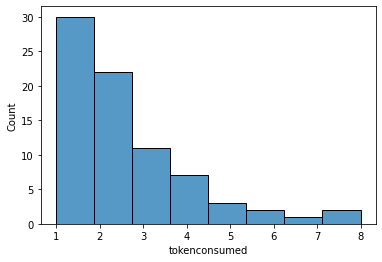

In [20]:
sns.histplot(data=predictordatedataframe[predictordatedataframe['tokenconsumed']>0], x="tokenconsumed")

<AxesSubplot:xlabel='AverageWaitingTime', ylabel='Count'>

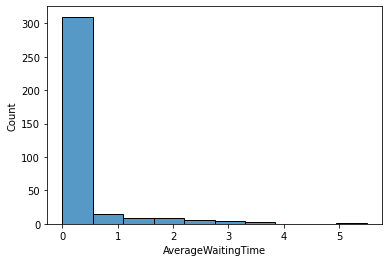

In [24]:
sns.histplot(data=predictordatedataframe, x="AverageWaitingTime")

In [22]:

def categorise(row):  
    if type( row['WaitingTime']) is int :
        return row['WaitingTime']
    return row['WaitingTime'].days
predictordatedataframe['WaitingDays'] = predictordatedataframe.apply(lambda row: categorise(row), axis=1)

def categorise(row):   
    if row['Count']==0:
        return 0
    return row['WaitingDays']/row['Count']

predictordatedataframe['AverageWaitingTime'] = predictordatedataframe.apply(lambda row: categorise(row), axis=1)


In [23]:
predictordatedataframe.sort_values(by='AverageWaitingTime')

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,WaitingDays,AverageWaitingTime
0,2018-01-02,1,0,1,0 days 01:00:00,1,0,0.000000
180,2018-07-01,0,0,0,0:00:00,0,0,0.000000
181,2018-07-02,0,0,0,0:00:00,0,0,0.000000
182,2018-07-03,0,0,0,0:00:00,0,0,0.000000
183,2018-07-04,1,0,1,0 days 02:00:00,1,0,0.000000
...,...,...,...,...,...,...,...,...
279,2018-10-08,2,2,5,22 days 04:44:00,7,22,3.142857
292,2018-10-21,2,0,4,13 days 08:00:00,4,13,3.250000
277,2018-10-06,1,0,4,14 days 08:00:00,4,14,3.500000
278,2018-10-07,1,0,5,18 days 10:00:00,5,18,3.600000


# for sample log n43 (target zone)
Input
   (n100, 'Record Invoice Receipt')->n43
    
Output-
    n43->[(n104, 'Record Subsequent Invoice'), (n106, 'Clear Invoice'), (n102, 'Remove Payment Block')] 

In [25]:

input_transition_set=set()
input_transition_label_set=set()
output_transition_set=set()
output_transition_label_set=set()
for start in ['n40','n42','n43','n44','n45']:
    initial_start=get_initial_start(start)
    input_transition_set|=set(get_input_transitions(net,initial_start))
    output_transition_set|=set(get_output_transitions(net,initial_start))
    
temp=input_transition_set.difference(output_transition_set)
output_transition_set.difference_update(input_transition_set)
input_transition_set=temp    

input_transition_label_set|=get_labels_set(input_transition_set)    
output_transition_label_set|=get_labels_set(output_transition_set)

print(input_transition_set)
print(input_transition_label_set)
print(output_transition_set)
print(output_transition_label_set)

token_produced=0
token_consumed=0
token_left=0
responsedf=pd.DataFrame(columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
for trace,case in zip(replayed_traces, log):
    last_event=None
    first_event=None
    if trace['trace_is_fit']==True:
        for active_trace in trace['activated_transitions']:
            if active_trace in input_transition_set :
                for events in case:
                    if events['concept:name'] in input_transition_label_set:
                        last_event=events
            if active_trace in output_transition_set:
                for events in case:
                    if events['concept:name'] in output_transition_label_set and first_event is None:
                        first_event=events
    if last_event is not None and first_event is not None:
        token_produced=token_produced+1
        token_consumed=token_consumed+1
        row_df = pd.DataFrame([[last_event['concept:name'], last_event['time:timestamp'],first_event['concept:name'], first_event['time:timestamp'], case.attributes['concept:name']]],columns= ['StartEvent','StartTime','EndEvent','EndTime','User'])
        responsedf = pd.concat([row_df, responsedf], ignore_index=True)
    
print(token_produced)
print(token_consumed)

responsedf

{(n99, 'Vendor creates invoice'), (n98, 'Record Goods Receipt')}
{'Vendor creates invoice', 'Record Goods Receipt'}
{(n106, 'Clear Invoice')}
{'Clear Invoice'}
937
937


,StartEvent,StartTime,EndEvent,EndTime,User
0,Record Goods Receipt,2018-12-20 08:56:00+01:00,Clear Invoice,2019-01-15 12:01:00+01:00,4508075036_00030
1,Record Goods Receipt,2018-12-20 08:57:00+01:00,Clear Invoice,2019-01-15 12:01:00+01:00,4508075035_00010
2,Record Goods Receipt,2018-12-11 09:10:00+01:00,Clear Invoice,2019-01-06 23:59:00+01:00,4508072287_00040
3,Record Goods Receipt,2018-12-06 17:40:00+01:00,Clear Invoice,2019-01-02 23:59:00+01:00,4508071546_00190
4,Record Goods Receipt,2018-11-28 17:37:00+01:00,Clear Invoice,2019-01-10 15:45:00+01:00,4508070342_00030
...,...,...,...,...,...
932,Record Goods Receipt,2018-01-31 12:31:00+01:00,Clear Invoice,2018-03-29 15:09:00+02:00,4507000662_00010
933,Vendor creates invoice,2018-01-31 23:59:00+01:00,Clear Invoice,2018-04-26 11:13:00+02:00,4507000595_00020
934,Record Goods Receipt,2018-01-08 08:10:00+01:00,Clear Invoice,2018-03-29 15:10:00+02:00,4507000400_00030
935,Record Goods Receipt,2018-01-05 13:22:00+01:00,Clear Invoice,2018-03-29 15:07:00+02:00,4507000259_00030


In [27]:
print(len(replayed_traces))

500


In [26]:
predictordf['StartDateTime'] = pd.to_datetime(predictordf['StartTime'], utc=True)
predictordf['StartDate'] = pd.to_datetime(predictordf['StartDateTime']).dt.date
predictordf['EndDateTime'] = pd.to_datetime(predictordf['EndTime'], utc=True)
predictordf['EndDate'] = pd.to_datetime(predictordf['EndDateTime']).dt.date
predictordf['TotalWaitingTime']=  (pd.to_datetime(predictordf['EndTime'], utc=True)-pd.to_datetime(predictordf['StartTime'], utc=True))
minstartdate=min(predictordf['StartDate'])
maxenddate=max(predictordf['EndDate'])

In [27]:
targetdatedataframe = pd.DataFrame({'date':pd.date_range(start=minstartdate, end=maxenddate),'tokenproduced':0,'tokenconsumed':0,'tokenleft':0,'WaitingTime':0,'Count':0})
targetdatedataframe 

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count
0,2018-01-02,0,0,0,0,0
1,2018-01-03,0,0,0,0,0
2,2018-01-04,0,0,0,0,0
3,2018-01-05,0,0,0,0,0
4,2018-01-06,0,0,0,0,0
...,...,...,...,...,...,...
349,2018-12-17,0,0,0,0,0
350,2018-12-18,0,0,0,0,0
351,2018-12-19,0,0,0,0,0
352,2018-12-20,0,0,0,0,0


In [28]:
from datetime import timedelta as td
for index, row in targetdatedataframe.iterrows():
    currentdate=row['date']
    produced=0
    left=0
    consumed=0
    waiting=td(days=0)
    waitingdays=0
    #print(type(waiting))
    count=0
    if currentdate.strftime('%Y-%m-%d')<='1999-10-13':
        continue
    print(currentdate.strftime('%Y-%m-%d'))
    for indexdata, rowdata in predictordf.iterrows():
        StartDate=rowdata['StartDate']
        EndDate=rowdata['EndDate']
        #TotalWaitingTime=rowdata['TotalWaitingTime']
        TotalWaitingTime=rowdata['TotalWaitingTime']
        #print(type(waiting)," ",type(TotalWaitingTime))
        WaitingTimeTillDate=currentdate+td(hours=24)
        if currentdate.date()==StartDate:
            produced=produced+1
        if currentdate.date()==EndDate:
            consumed=consumed+1
            WaitingTimeTillDate=rowdata['EndDateTime']
        if currentdate.date()<EndDate and currentdate.date()>=StartDate:
            left=left+1
        if currentdate.date()<=EndDate and currentdate.date()>=StartDate:
            TotalWaitingTime=WaitingTimeTillDate.replace(tzinfo=None)-rowdata['StartDateTime'].replace(tzinfo=None)
            if waiting is None:
                waiting=TotalWaitingTime
            else:
                if waiting.days<100000:
                    waiting=waiting+TotalWaitingTime
                    waitingdays=waiting.days
                else :
                    waitingdays=TotalWaitingTime.days+waitingdays
            count=count+1
    targetdatedataframe.at[index, 'tokenproduced']=produced
    targetdatedataframe.at[index, 'tokenconsumed']=consumed
    targetdatedataframe.at[index, 'tokenleft']=left
    if waiting.days<100000:
        targetdatedataframe.at[index, 'WaitingTime']=waiting
    else:
        targetdatedataframe.at[index, 'WaitingTime']=waitingdays
    targetdatedataframe.at[index, 'Count']=count

2018-01-02
2018-01-03
2018-01-04
2018-01-05
2018-01-06
2018-01-07
2018-01-08
2018-01-09
2018-01-10
2018-01-11
2018-01-12
2018-01-13
2018-01-14
2018-01-15
2018-01-16
2018-01-17
2018-01-18
2018-01-19
2018-01-20
2018-01-21
2018-01-22
2018-01-23
2018-01-24
2018-01-25
2018-01-26
2018-01-27
2018-01-28
2018-01-29
2018-01-30
2018-01-31
2018-02-01
2018-02-02
2018-02-03
2018-02-04
2018-02-05
2018-02-06
2018-02-07
2018-02-08
2018-02-09
2018-02-10
2018-02-11
2018-02-12
2018-02-13
2018-02-14
2018-02-15
2018-02-16
2018-02-17
2018-02-18
2018-02-19
2018-02-20
2018-02-21
2018-02-22
2018-02-23
2018-02-24
2018-02-25
2018-02-26
2018-02-27
2018-02-28
2018-03-01
2018-03-02
2018-03-03
2018-03-04
2018-03-05
2018-03-06
2018-03-07
2018-03-08
2018-03-09
2018-03-10
2018-03-11
2018-03-12
2018-03-13
2018-03-14
2018-03-15
2018-03-16
2018-03-17
2018-03-18
2018-03-19
2018-03-20
2018-03-21
2018-03-22
2018-03-23
2018-03-24
2018-03-25
2018-03-26
2018-03-27
2018-03-28
2018-03-29
2018-03-30
2018-03-31
2018-04-01
2018-04-02

In [29]:
index=targetdatedataframe.index.values
targetdatedataframe.insert( 0, column='index',value = index+1)

targetdatedataframe['totaltokenleft'] = targetdatedataframe['tokenleft'].cumsum()
def categorise(row):   
    if row['index']==0:
        return 0
    return row['totaltokenleft']/row['index']

targetdatedataframe['Averagetokenleft'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)
targetdatedataframe['totaltokenconsumed'] = targetdatedataframe['tokenconsumed'].cumsum()
def categorise(row):   
    if row['index']==0:
        return 0
    return row['totaltokenconsumed']/row['index']

targetdatedataframe['Averagetokenconsumed'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)
targetdatedataframe['totaltokenproduced'] = targetdatedataframe['tokenproduced'].cumsum()
def categorise(row):   
    if row['index']==0:
        return 0
    return row['totaltokenproduced']/row['index']

targetdatedataframe['Averagetokenproduced'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)

In [61]:
#targetdatedataframe.to_csv(r'C:\Users\bittu\RWTH\Thesis\easyroadfine2000sampltargetdatedataframe.csv', index= False, header=True)
targetdatedataframe = pd.read_csv(r'C:\Users\bittu\RWTH\Thesis\bpi2019datasetresponseresponsedatedataframe.csv')
targetdatedataframe['date']=pd.to_datetime(targetdatedataframe['date'])
targetdatedataframe['WaitingTime']=pd.to_timedelta(targetdatedataframe['WaitingTime'])

In [30]:
def categorise(row):  
    if type( row['WaitingTime']) is int :
        return row['WaitingTime']
    return row['WaitingTime'].days
targetdatedataframe['WaitingDays'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)

def categorise(row):   
    if row['Count']==0:
        return 0
    return row['WaitingDays']/row['Count']

targetdatedataframe['AverageWaitingTime'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)


<AxesSubplot:xlabel='AverageWaitingTime', ylabel='Count'>

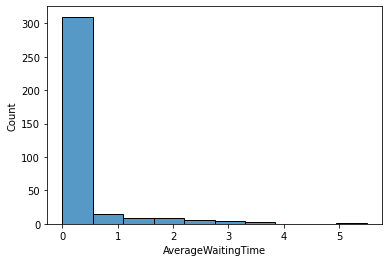

In [31]:
sns.histplot(data=targetdatedataframe, x="AverageWaitingTime")

<AxesSubplot:xlabel='AverageWaitingTime', ylabel='Count'>

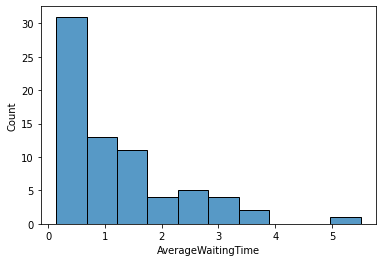

In [32]:
sns.histplot(data=targetdatedataframe[targetdatedataframe['AverageWaitingTime']>0], x="AverageWaitingTime")

<AxesSubplot:xlabel='date', ylabel='AverageWaitingTime'>

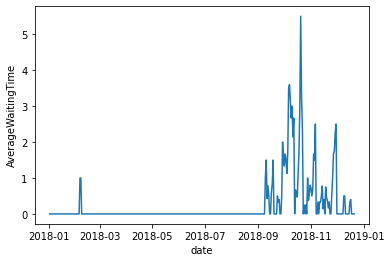

In [33]:
sns.lineplot(data=targetdatedataframe, x="date", y="AverageWaitingTime")

In [37]:
targetdatedataframe[targetdatedataframe['AverageWaitingTime']>1.24].sort_values(by='AverageWaitingTime')

,index,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,totaltokenleft,Averagetokenleft,totaltokenconsumed,Averagetokenconsumed,totaltokenproduced,Averagetokenproduced,WaitingDays,AverageWaitingTime
272,273,2018-10-01,1,1,2,4 days 14:22:00,3,60,0.219780,45,0.164835,47,0.172161,4,1.333333
251,252,2018-09-10,0,1,1,3 days 10:31:00,2,20,0.079365,17,0.067460,18,0.071429,3,1.500000
259,260,2018-09-18,0,2,0,3 days 04:48:00,2,41,0.157692,33,0.126923,33,0.126923,3,1.500000
271,272,2018-09-30,1,0,2,3 days 04:00:00,2,58,0.213235,44,0.161765,46,0.169118,3,1.500000
274,275,2018-10-03,2,1,3,6 days 15:30:00,4,65,0.236364,47,0.170909,50,0.181818,6,1.500000
307,308,2018-11-05,1,2,2,6 days 21:14:00,4,180,0.584416,116,0.376623,118,0.383117,6,1.500000
273,274,2018-10-02,1,1,2,5 days 13:50:00,3,62,0.226277,46,0.167883,48,0.175182,5,1.666667
329,330,2018-11-27,1,0,3,5 days 03:00:00,3,241,0.730303,162,0.490909,165,0.500000,5,1.666667
306,307,2018-11-04,0,0,3,5 days 03:00:00,3,178,0.579805,114,0.371336,117,0.381107,5,1.666667
276,277,2018-10-05,0,4,3,12 days 20:46:00,7,75,0.270758,52,0.187726,55,0.198556,12,1.714286


In [36]:
AverageWaitingTimemean=targetdatedataframe[targetdatedataframe['AverageWaitingTime']!=0][["AverageWaitingTime"]].mean()
print(AverageWaitingTimemean)

AverageWaitingTime    1.240201
dtype: float64


In [38]:
def categorise(row):   
    if row['AverageWaitingTime'] >=1.23 :
        return 1
    return 0

targetdatedataframe['delayed'] = targetdatedataframe.apply(lambda row: categorise(row), axis=1)

In [42]:
targetdatedataframe

,index,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,totaltokenleft,Averagetokenleft,totaltokenconsumed,Averagetokenconsumed,totaltokenproduced,Averagetokenproduced,WaitingDays,AverageWaitingTime,delayed
0,1,2018-01-02,1,0,1,0 days 01:00:00,1,1,1.000000,0,0.000000,1,1.000000,0,0.0,0
1,2,2018-01-03,0,1,0,0 days 13:51:00,1,1,0.500000,1,0.500000,1,0.500000,0,0.0,0
2,3,2018-01-04,0,0,0,0:00:00,0,1,0.333333,1,0.333333,1,0.333333,0,0.0,0
3,4,2018-01-05,0,0,0,0:00:00,0,1,0.250000,1,0.250000,1,0.250000,0,0.0,0
4,5,2018-01-06,0,0,0,0:00:00,0,1,0.200000,1,0.200000,1,0.200000,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,350,2018-12-17,2,3,2,2 days 01:47:00,5,264,0.754286,181,0.517143,183,0.522857,2,0.4,0
350,351,2018-12-18,0,2,0,0 days 16:52:00,2,264,0.752137,183,0.521368,183,0.521368,0,0.0,0
351,352,2018-12-19,0,0,0,0:00:00,0,264,0.750000,183,0.519886,183,0.519886,0,0.0,0
352,353,2018-12-20,2,0,2,0 days 02:00:00,2,266,0.753541,183,0.518414,185,0.524079,0,0.0,0


# Creating the dataframe for prediction

In [39]:
#originalpredictordatedataframe=\
predictordatedataframe=originalpredictordatedataframe
targetdatedataframe=originaltargetdatedataframe

In [40]:
originaltargetdatedataframe=targetdatedataframe
originalpredictordatedataframe=predictordatedataframe

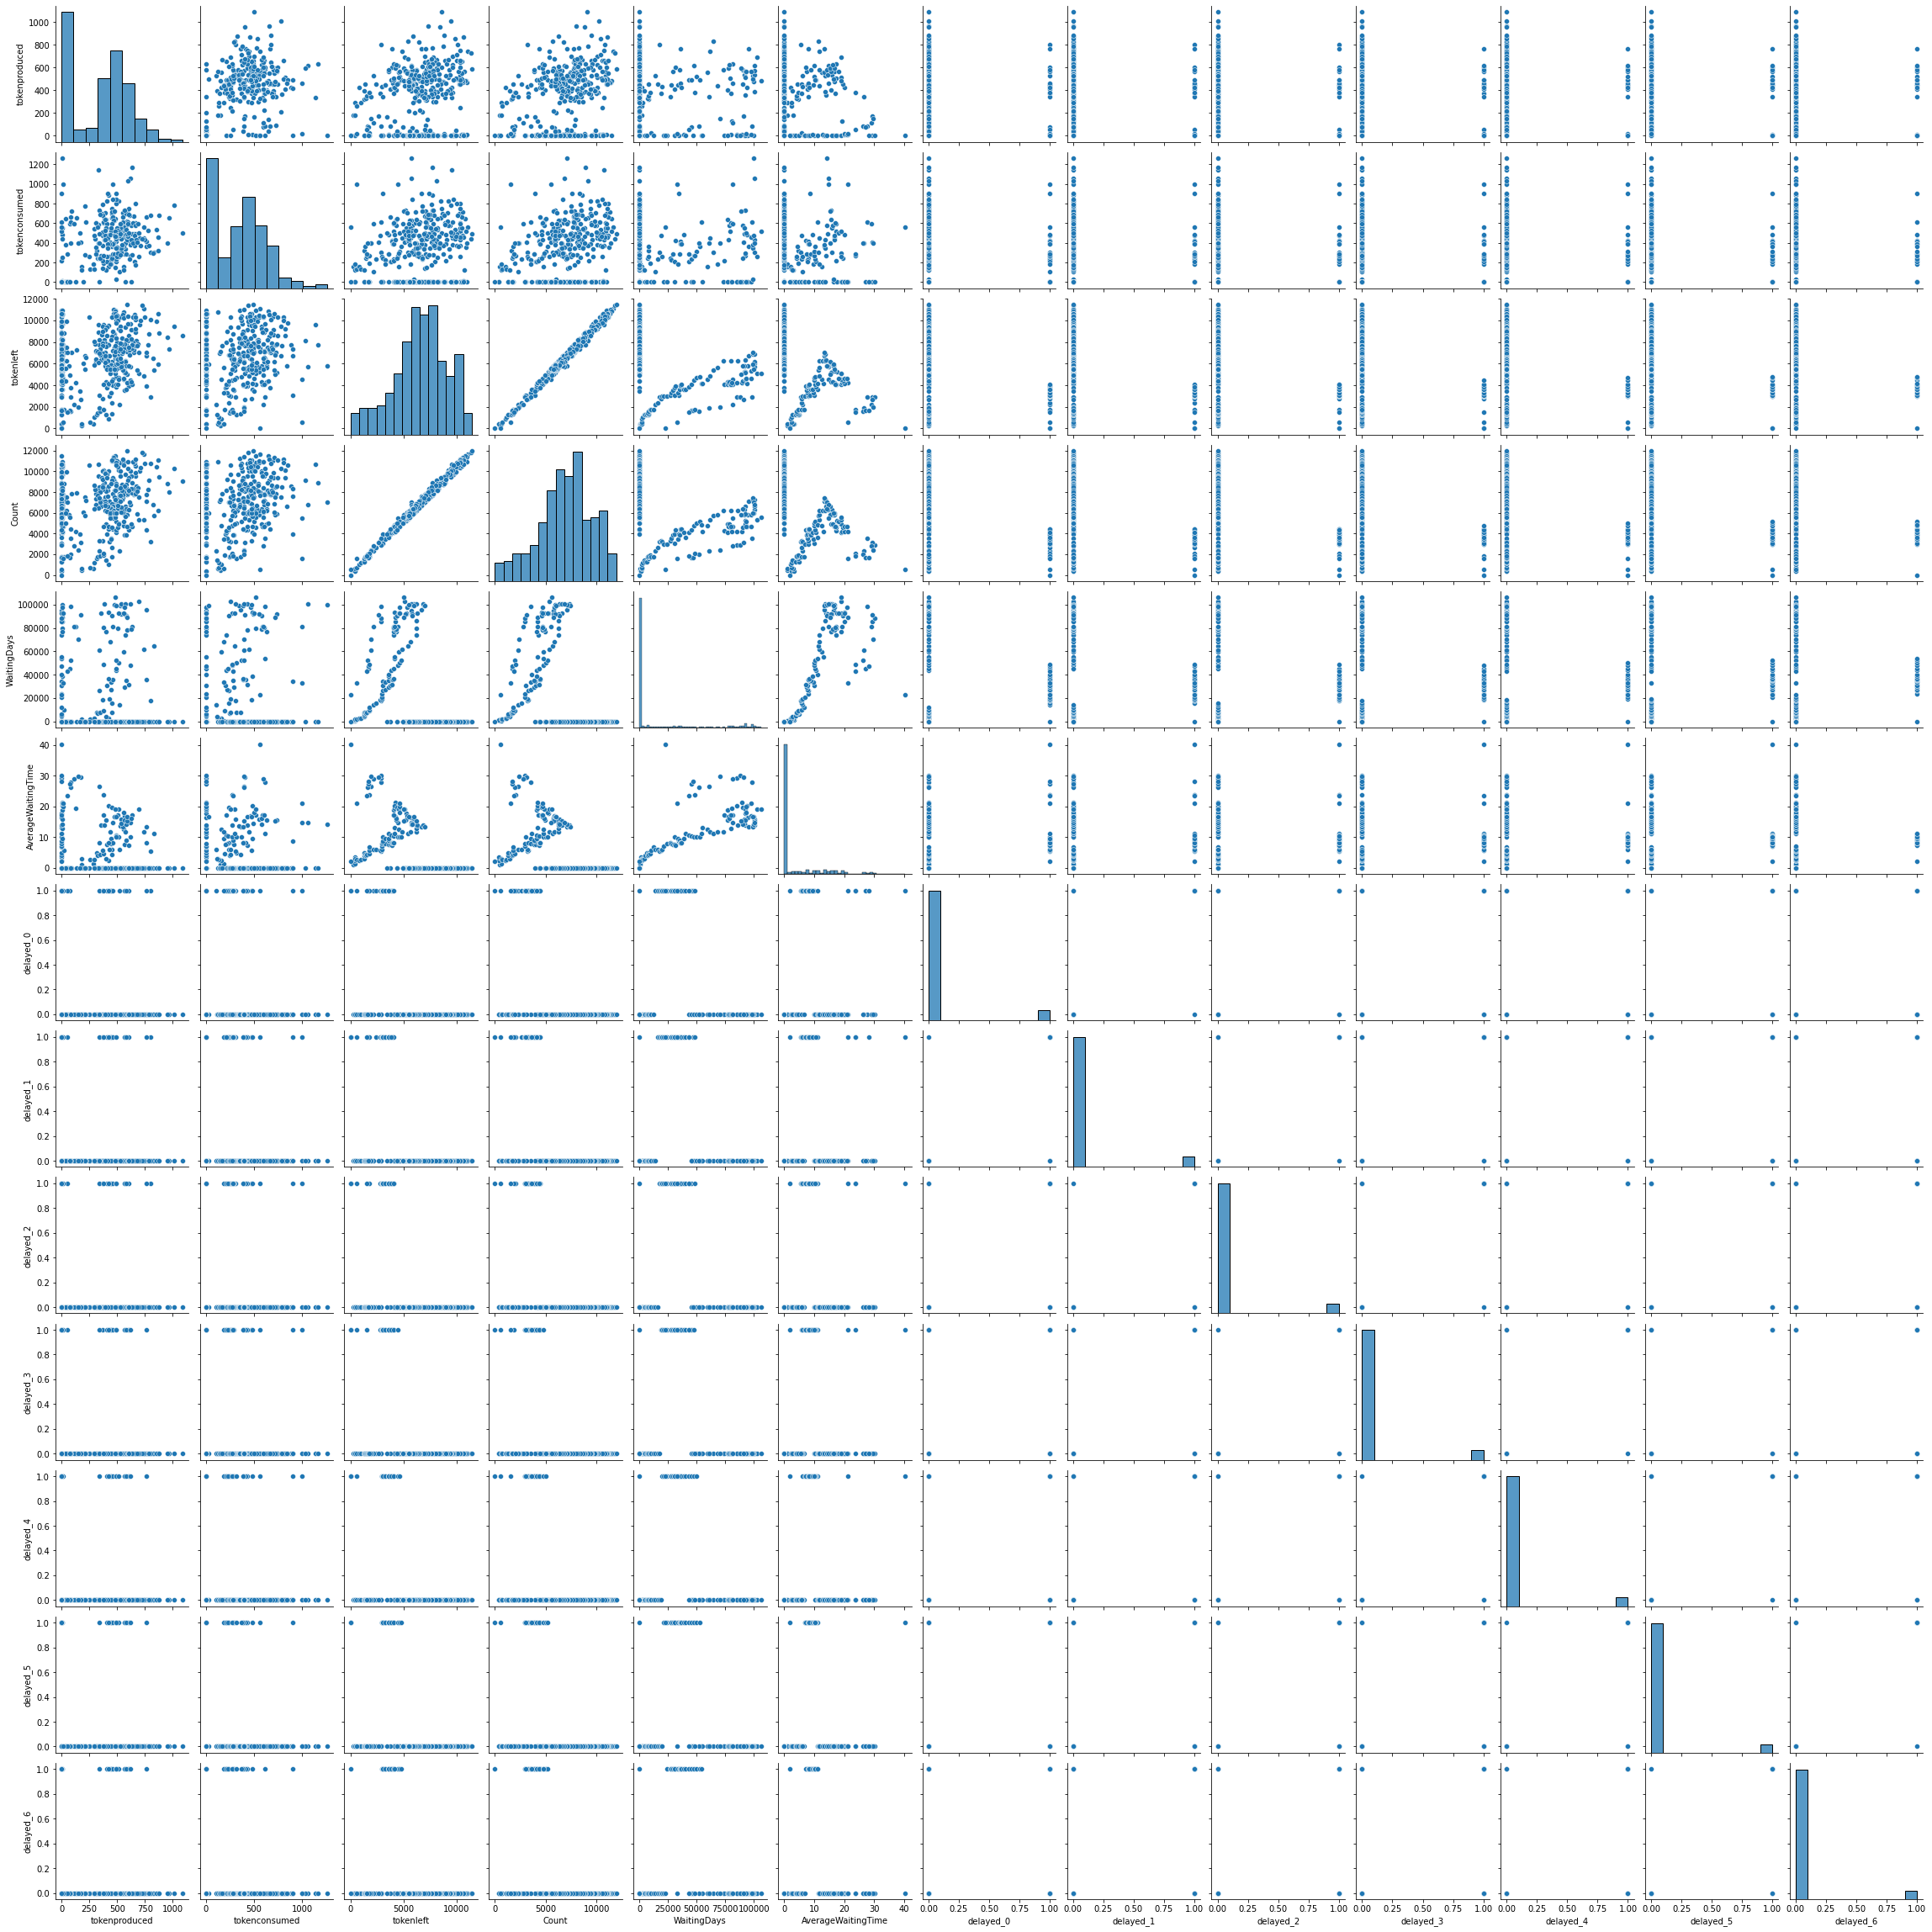

In [80]:
sns.pairplot(predictordatedataframe)

In [43]:
predictordatedataframe=predictordatedataframe.merge(targetdatedataframe[['date','tokenproduced', 'tokenconsumed', 'tokenleft','delayed', 'Count',
       'AverageWaitingTime']], on='date', how='left')

In [44]:
import datetime
#add seven days
def categorise(row,numdays):   
    return row['date'] -  datetime.timedelta(days=1)
for i in range (7):
    predictordatedataframe=predictordatedataframe.merge(targetdatedataframe[['date','delayed']].rename({'delayed': 'delayed_'+str(i)}, axis=1), on='date', how='left')
    targetdatedataframe['date'] = targetdatedataframe.apply(lambda row: categorise(row,i), axis=1)

In [63]:
#test=predictordatedataframe.loc[(predictordatedataframe['index'] ==91 )]
predictordatedataframe=predictordatedataframe.drop(predictordatedataframe.index>=300)
#test=predictordatedataframe.loc[predictordatedataframe.index>=300]

KeyError: '[False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n False False False False False False False False False False False False\n  True  True  True  True  True  True  True  True  True  True  True  True\n  True  True  True  True  True  True  True  True  True  True  True  True\n  True  True  True  True  True  True  True  True  True  True  True  True\n  True  True  True  True  True  True  True  True  True  True  True  True] not found in axis'

In [60]:
test

,date,tokenproduced_x,tokenconsumed_x,tokenleft_x,WaitingTime,Count_x,WaitingDays,AverageWaitingTime_x,tokenproduced_y,tokenconsumed_y,...,delayed,Count_y,AverageWaitingTime_y,delayed_0,delayed_1,delayed_2,delayed_3,delayed_4,delayed_5,delayed_6
300,2018-10-29,6,1,7,3 days 17:08:00,8,3,0.375000,6,1,...,0,8,0.375000,0,0.0,0.0,0.0,0.0,0.0,1.0
301,2018-10-30,2,6,3,5 days 09:33:00,9,5,0.555556,2,6,...,0,9,0.555556,0,0.0,0.0,0.0,0.0,1.0,1.0
302,2018-10-31,2,2,3,4 days 21:20:00,5,4,0.800000,2,2,...,0,5,0.800000,0,0.0,0.0,0.0,1.0,1.0,1.0
303,2018-11-01,4,3,4,5 days 08:57:00,7,5,0.714286,4,3,...,0,7,0.714286,0,0.0,0.0,1.0,1.0,1.0,0.0
304,2018-11-02,0,3,1,2 days 02:59:00,4,2,0.500000,0,3,...,0,4,0.500000,0,0.0,1.0,1.0,1.0,0.0,0.0
305,2018-11-03,2,0,3,2 days 03:00:00,3,2,0.666667,2,0,...,0,3,0.666667,0,1.0,1.0,1.0,0.0,0.0,0.0
306,2018-11-04,0,0,3,5 days 03:00:00,3,5,1.666667,0,0,...,1,3,1.666667,1,1.0,1.0,0.0,0.0,0.0,0.0
307,2018-11-05,1,2,2,6 days 21:14:00,4,6,1.500000,1,2,...,1,4,1.500000,1,1.0,0.0,0.0,0.0,0.0,0.0
308,2018-11-06,0,2,0,5 days 00:05:00,2,5,2.500000,0,2,...,1,2,2.500000,1,0.0,0.0,0.0,0.0,0.0,0.0
309,2018-11-07,1,0,1,0 days 01:00:00,1,0,0.000000,1,0,...,0,1,0.000000,0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
predictordatedataframe=predictordatedataframe.dropna()
predictordatedataframe.count()

date                    348
tokenproduced_x         348
tokenconsumed_x         348
tokenleft_x             348
WaitingTime             348
Count_x                 348
WaitingDays             348
AverageWaitingTime_x    348
tokenproduced_y         348
tokenconsumed_y         348
tokenleft_y             348
delayed                 348
Count_y                 348
AverageWaitingTime_y    348
delayed_0               348
delayed_1               348
delayed_2               348
delayed_3               348
delayed_4               348
delayed_5               348
delayed_6               348
dtype: int64

In [74]:
predictordatedataframe

,date,tokenproduced,tokenconsumed,tokenleft,WaitingTime,Count,WaitingDays,AverageWaitingTime,delayed_0,delayed_1,delayed_2,delayed_3,delayed_4,delayed_5,delayed_6
8,2018-01-11,180,153,298,505 days 20:19:00,451,505,1.119734,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2018-01-12,288,184,402,701 days 02:44:00,586,701,1.196246,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,2018-01-13,0,0,402,955 days 09:00:00,402,955,2.375622,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,2018-01-14,0,0,402,1357 days 09:00:00,402,1357,3.375622,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2018-01-15,180,121,461,1759 days 04:54:00,582,1759,3.022337,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376,2019-01-14,380,269,1775,48542 days 02:13:00,2044,48542,23.748532,1.0,1.0,1.0,0.0,0.0,0.0,0.0
377,2019-01-15,52,283,1544,43162 days 07:34:00,1827,43162,23.624521,1.0,1.0,1.0,1.0,0.0,0.0,0.0
378,2019-01-16,15,997,562,32944 days 20:23:00,1559,32944,21.131495,1.0,1.0,1.0,1.0,1.0,0.0,0.0
379,2019-01-17,1,562,1,22726 days 09:43:00,563,22726,40.365897,1.0,1.0,1.0,1.0,1.0,1.0,0.0


184    0
92     0
112    0
128    0
302    0
      ..
201    0
144    0
305    0
294    0
225    0
Name: delayed_0, Length: 105, dtype: int64
     0
0    0
1    0
2    0
3    0
4    0
..  ..
100  0
101  0
102  0
103  0
104  0

[105 rows x 1 columns]
Mean absolute error LR- 0.0
Mean Squared error LR- 0.0
Accuracy: 1.0
F1: 1.0
Precision: 1.0
Recall: 1.0


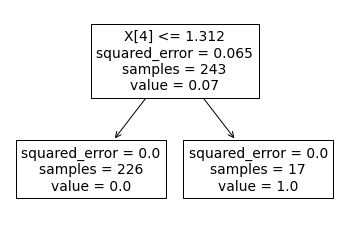

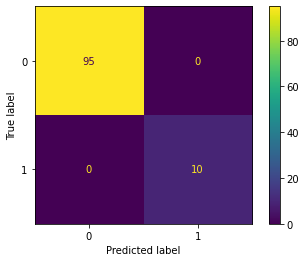

318    0.0
148    0.0
225    0.0
77     0.0
340    0.0
      ... 
0      0.0
207    0.0
213    0.0
67     0.0
58     0.0
Name: delayed_1, Length: 105, dtype: float64
     0
0    0
1    0
2    0
3    0
4    0
..  ..
100  0
101  0
102  0
103  0
104  0

[105 rows x 1 columns]
Mean absolute error LR- 0.01904761904761905
Mean Squared error LR- 0.13801311186847084
Accuracy: 0.9809523809523809
F1: 0.9234693877551021
Precision: 0.9898989898989898
Recall: 0.875


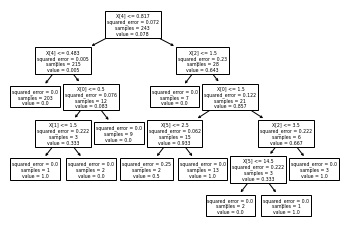

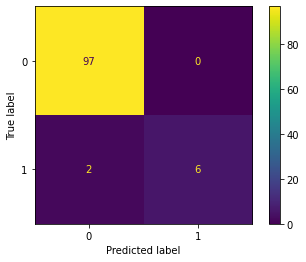

28     0.0
132    0.0
218    0.0
118    0.0
146    0.0
      ... 
77     0.0
245    0.0
276    1.0
66     0.0
215    0.0
Name: delayed_2, Length: 105, dtype: float64
     0
0    0
1    0
2    0
3    0
4    0
..  ..
100  0
101  0
102  1
103  0
104  0

[105 rows x 1 columns]
Mean absolute error LR- 0.0761904761904762
Mean Squared error LR- 0.2760262237369417
Accuracy: 0.9238095238095239
F1: 0.6938775510204082
Precision: 0.77
Recall: 0.65625


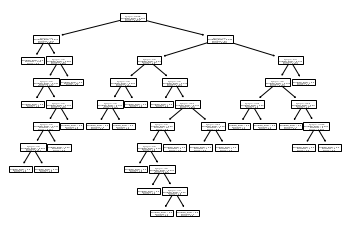

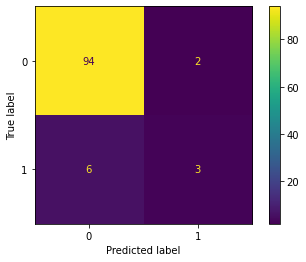

24     0.0
83     0.0
275    1.0
259    0.0
315    0.0
      ... 
135    0.0
37     0.0
104    0.0
0      0.0
200    0.0
Name: delayed_3, Length: 105, dtype: float64
     0
0    0
1    0
2    1
3    0
4    1
..  ..
100  0
101  0
102  0
103  0
104  0

[105 rows x 1 columns]
Mean absolute error LR- 0.06666666666666667
Mean Squared error LR- 0.2581988897471611
Accuracy: 0.9333333333333333
F1: 0.7759829320329168
Precision: 0.7394736842105263
Recall: 0.8316326530612246


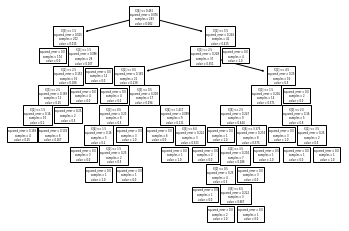

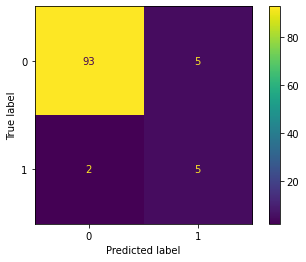

214    0.0
291    0.0
64     0.0
245    0.0
330    0.0
      ... 
204    0.0
107    0.0
293    0.0
83     0.0
157    0.0
Name: delayed_4, Length: 105, dtype: float64
     0
0    0
1    1
2    0
3    0
4    1
..  ..
100  0
101  0
102  0
103  0
104  0

[105 rows x 1 columns]
Mean absolute error LR- 0.09523809523809523
Mean Squared error LR- 0.3086066999241838
Accuracy: 0.9047619047619048
F1: 0.6961805555555556
Precision: 0.75
Recall: 0.6658607350096712


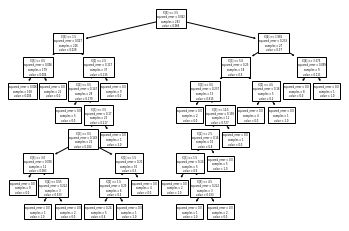

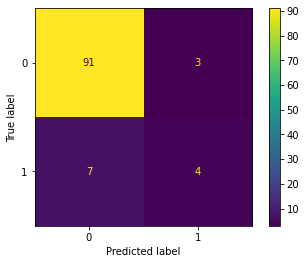

346    0.0
209    0.0
339    0.0
71     0.0
344    0.0
      ... 
177    0.0
193    0.0
195    0.0
229    0.0
279    0.0
Name: delayed_5, Length: 105, dtype: float64
     0
0    0
1    0
2    0
3    0
4    1
..  ..
100  0
101  0
102  0
103  0
104  0

[105 rows x 1 columns]
Mean absolute error LR- 0.12380952380952381
Mean Squared error LR- 0.3518657752744984
Accuracy: 0.8761904761904762
F1: 0.467005076142132
Precision: 0.46938775510204084
Recall: 0.46464646464646464


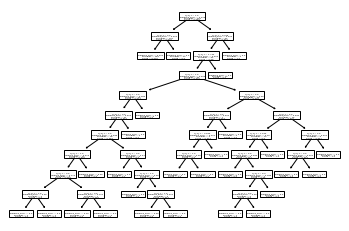

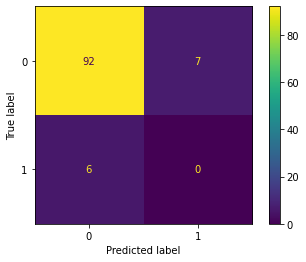

192    0.0
47     0.0
216    0.0
58     0.0
113    0.0
      ... 
273    1.0
14     0.0
143    0.0
122    0.0
25     0.0
Name: delayed_6, Length: 105, dtype: float64
     0
0    0
1    0
2    0
3    0
4    0
..  ..
100  0
101  0
102  0
103  0
104  0

[105 rows x 1 columns]
Mean absolute error LR- 0.08571428571428572
Mean Squared error LR- 0.29277002188455997
Accuracy: 0.9142857142857143
F1: 0.4776119402985075
Precision: 0.47058823529411764
Recall: 0.48484848484848486


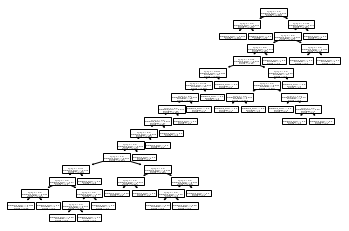

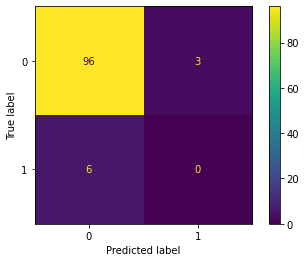

In [66]:
from sklearn import tree,metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

def traindtmultiple(y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    clf = tree.DecisionTreeRegressor()
    clf = clf.fit(x_train, y_train)
    prediction=clf.predict(x_test)
    tree.plot_tree(clf)
    Y_test_pred = pd.DataFrame(prediction).applymap(lambda x: 1 if x>0.5 else 0)
    #Y_test_pred = pd.DataFrame(prediction)
    print(y_test)
    print(Y_test_pred)
    print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
    metrics.mean_squared_error(y_test, Y_test_pred)
    print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
    print("Accuracy:",accuracy_score(y_test, Y_test_pred))
    print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
    print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
    print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
    cm = confusion_matrix(y_test, Y_test_pred)
    cm = confusion_matrix(y_test, Y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

x = predictordatedataframe[['tokenproduced_x', 'tokenconsumed_x', 'tokenleft_x','Count_x','AverageWaitingTime_x','WaitingDays']]
for i in range(7):
    y = predictordatedataframe['delayed_'+str(i)].fillna(0)
    traindtmultiple(y)


107    0
74     0
338    0
307    1
197    0
      ..
142    0
63     0
205    0
147    0
77     0
Name: delayed_0, Length: 105, dtype: int64
     0
0    1
1    1
2    1
3    1
4    1
..  ..
100  1
101  1
102  1
103  1
104  1

[105 rows x 1 columns]
Mean absolute error LR- 0.9714285714285714
Mean Squared error LR- 0.9856107606091623
Accuracy: 0.02857142857142857
F1: 0.02777777777777778
Precision: 0.01485148514851485
Recall: 0.21428571428571427


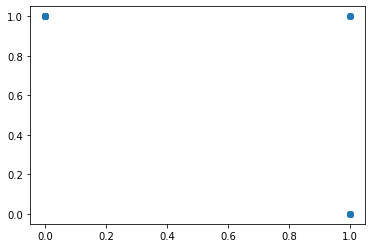

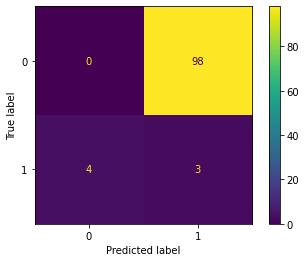

171    0.0
22     0.0
125    0.0
7      0.0
320    0.0
      ... 
78     0.0
8      0.0
319    0.0
306    1.0
112    0.0
Name: delayed_1, Length: 105, dtype: float64
     0
0    1
1    1
2    1
3    1
4    0
..  ..
100  1
101  1
102  1
103  0
104  1

[105 rows x 1 columns]
Mean absolute error LR- 0.9619047619047619
Mean Squared error LR- 0.9807674351775563
Accuracy: 0.0380952380952381
F1: 0.03809523809523809
Precision: 0.12152777777777778
Recall: 0.12152777777777778


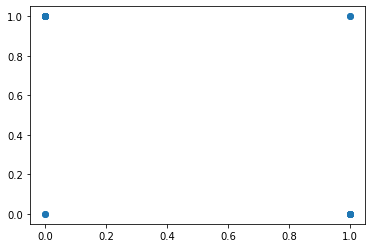

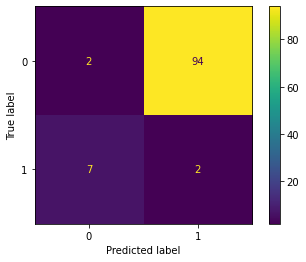

212    0.0
235    0.0
68     0.0
80     0.0
97     0.0
      ... 
100    0.0
174    0.0
304    1.0
132    0.0
137    0.0
Name: delayed_2, Length: 105, dtype: float64
     0
0    1
1    1
2    1
3    1
4    1
..  ..
100  1
101  1
102  1
103  1
104  1

[105 rows x 1 columns]
Mean absolute error LR- 0.9238095238095239
Mean Squared error LR- 0.9611501047232549
Accuracy: 0.0761904761904762
F1: 0.07585518555484984
Precision: 0.3997524752475248
Recall: 0.4318181818181818


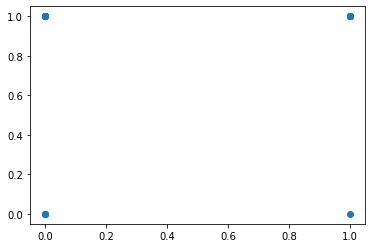

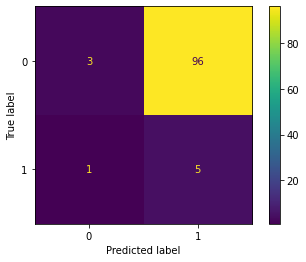

302    0.0
199    0.0
308    0.0
83     0.0
64     0.0
      ... 
329    1.0
207    0.0
295    0.0
150    0.0
75     0.0
Name: delayed_3, Length: 105, dtype: float64
     0
0    1
1    1
2    1
3    1
4    1
..  ..
100  1
101  1
102  1
103  1
104  1

[105 rows x 1 columns]
Mean absolute error LR- 0.9238095238095239
Mean Squared error LR- 0.9611501047232549
Accuracy: 0.0761904761904762
F1: 0.07316407316407317
Precision: 0.20098039215686275
Recall: 0.3940972222222222


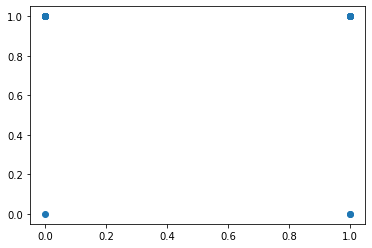

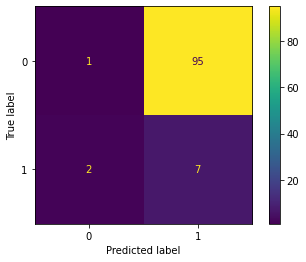

66     0.0
256    0.0
189    0.0
231    0.0
24     0.0
      ... 
99     0.0
261    0.0
277    1.0
262    0.0
193    0.0
Name: delayed_4, Length: 105, dtype: float64
     0
0    1
1    1
2    1
3    1
4    1
..  ..
100  1
101  1
102  1
103  1
104  1

[105 rows x 1 columns]
Mean absolute error LR- 0.9523809523809523
Mean Squared error LR- 0.9759000729485332
Accuracy: 0.047619047619047616
F1: 0.046840958605664486
Precision: 0.18627450980392157
Recall: 0.33838383838383834


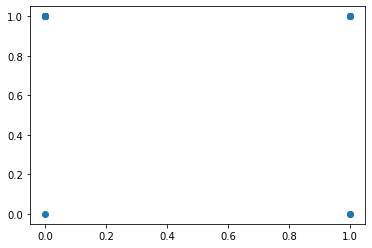

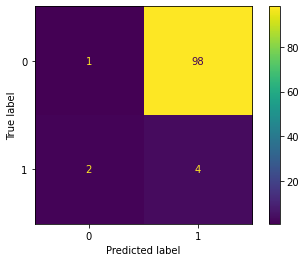

246    1.0
305    0.0
155    0.0
174    0.0
256    0.0
      ... 
19     0.0
254    1.0
328    0.0
112    0.0
265    1.0
Name: delayed_5, Length: 105, dtype: float64
     0
0    1
1    1
2    1
3    1
4    1
..  ..
100  1
101  1
102  1
103  1
104  1

[105 rows x 1 columns]
Mean absolute error LR- 0.9142857142857143
Mean Squared error LR- 0.9561828874675149
Accuracy: 0.08571428571428572
F1: 0.08363636363636365
Precision: 0.2846534653465347
Recall: 0.3993055555555556


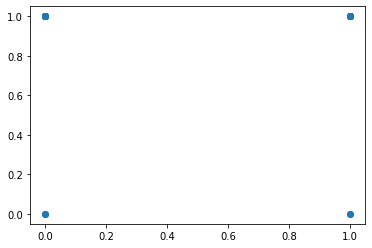

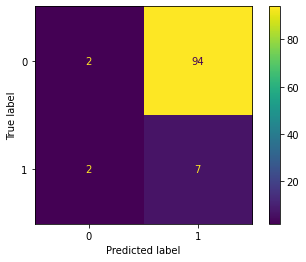

102    0.0
255    0.0
98     0.0
336    0.0
123    0.0
      ... 
50     0.0
16     0.0
107    0.0
280    0.0
59     0.0
Name: delayed_6, Length: 105, dtype: float64
     0
0    1
1    1
2    1
3    1
4    1
..  ..
100  1
101  1
102  1
103  1
104  1

[105 rows x 1 columns]
Mean absolute error LR- 0.9619047619047619
Mean Squared error LR- 0.9807674351775563
Accuracy: 0.0380952380952381
F1: 0.03774612104164776
Precision: 0.2645631067961165
Recall: 0.37995049504950495


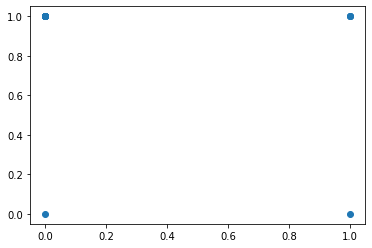

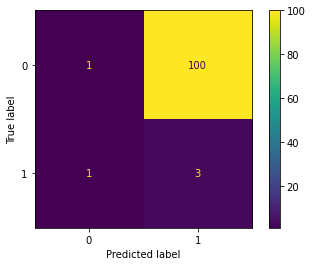

In [65]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
def trainlrmultiple(y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
    model = LinearRegression()
    model.fit(x_train, y_train)
    pd.DataFrame(model.coef_, x.columns, columns = ['Coeff'])
    #Y_test_pred = pd.DataFrame(model.predict(x_test)).applymap(lambda x: 1 if x>0.5 else 0)
    Y_test_pred = pd.DataFrame(model.predict(x_test)).applymap(lambda x: 0 if x>0.5 else 1)
    plt.scatter(y_test, Y_test_pred)
    from sklearn import metrics
    print(y_test)
    print(Y_test_pred)
    print("Mean absolute error LR-",metrics.mean_absolute_error(y_test, Y_test_pred))
    metrics.mean_squared_error(y_test, Y_test_pred)
    print("Mean Squared error LR-",np.sqrt(metrics.mean_squared_error(y_test, Y_test_pred)))
    print("Accuracy:",accuracy_score(y_test, Y_test_pred))
    print("F1:",f1_score(y_test, Y_test_pred, average="macro"))
    print("Precision:",precision_score(y_test, Y_test_pred, average="macro"))
    print("Recall:",recall_score(y_test, Y_test_pred, average="macro"))
    cm = confusion_matrix(y_test, Y_test_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

x = predictordatedataframe[['tokenproduced_x', 'tokenconsumed_x', 'tokenleft_x','Count_x','AverageWaitingTime_x','WaitingDays']]
for i in range(7):
    y = predictordatedataframe['delayed_'+str(i)].fillna(0)
    trainlrmultiple(y)
